In [567]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from torch import nn,optim

train_path='./train.tsv'
test_path='./test.tsv'
vocab_path='./vocab.txt'

train_data=pd.read_csv('./train.tsv',sep='\t')
test_data=pd.read_csv('./test.tsv',sep='\t')

train_data.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [568]:
test_data.head(10)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [569]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

True
1
Tesla P100-PCIE-16GB


In [0]:
def make_vocab(vocab_path,train=None):
  vocab={}
  if os.path.isfile(vocab_path):
    file=open(vocab_path, 'r',encoding='utf-8')
    for line in file.readlines():
      line=line.rstrip()
      key,value=line.split('\t')
      vocab[key]=value
    file.close()
  else:
    count_dict=defaultdict(int)
    for index,data in tqdm(train.iterrows(), desc='make vocab',total=len(train)):
      sentence=data['Phrase'].lower()
      tokens=sentence.split(' ')
      for token in tokens:
        count_dict[token]+=1
    file=open(vocab_path,'w',encoding='utf-8')
    file.write('[UNK]\t0\n[PAD]\t1\n')
    vocab={'[UNK]':0, '[PAD]':1}
    for index, (token,count) in enumerate(sorted(count_dict.items(),reverse=True, key=lambda item: item[1])):
      vocab[token]=index+2
      file.write(token + '\t' + str(index + 2)+'\n')
    file.close()

  return vocab

In [0]:
vocab=make_vocab(vocab_path,train_data)

In [572]:
vocab

{'[UNK]': '0',
 '[PAD]': '1',
 'the': '2',
 ',': '3',
 'a': '4',
 'of': '5',
 'and': '6',
 'to': '7',
 '.': '8',
 "'s": '9',
 'in': '10',
 'is': '11',
 'that': '12',
 'it': '13',
 'as': '14',
 'with': '15',
 'for': '16',
 'its': '17',
 'film': '18',
 'an': '19',
 'movie': '20',
 'this': '21',
 'but': '22',
 'be': '23',
 'you': '24',
 'on': '25',
 "n't": '26',
 'by': '27',
 'more': '28',
 'his': '29',
 'about': '30',
 'one': '31',
 'not': '32',
 'at': '33',
 'or': '34',
 'from': '35',
 'than': '36',
 '--': '37',
 'all': '38',
 'have': '39',
 'like': '40',
 'are': '41',
 'has': '42',
 "'": '43',
 'so': '44',
 'story': '45',
 '-rrb-': '46',
 'out': '47',
 'who': '48',
 'most': '49',
 'into': '50',
 'too': '51',
 'up': '52',
 '-lrb-': '53',
 'good': '54',
 'if': '55',
 '`': '56',
 'what': '57',
 'their': '58',
 '...': '59',
 'characters': '60',
 'much': '61',
 '``': '62',
 "''": '63',
 'can': '64',
 'i': '65',
 'no': '66',
 'your': '67',
 'time': '68',
 'comedy': '69',
 'just': '70',
 'som

In [0]:

device=torch.device('cuda:0')
 
max_len=50 #문장최대길이(데이터 길이 너무 길어지면 반영 잘 안됨)
input_size=len(vocab) #고정(단어사전 개수)
embed_size=50
hidden_size=100
output_size=5 #고정(라벨개수)
batch_size=1024
epochs=13
lr=0.001

In [0]:
def read_data(train,test,vocab,max_len):
  x_train=np.ones(shape=(len(train),max_len))
  for i,data in tqdm(enumerate(train['Phrase']),desc='make x_train data',total=len(train)):
    data=data.lower()
    tokens=data.split(' ')
    for j,token in enumerate(tokens):
      if j==50:
        break
      x_train[i][j]=vocab[token]
  x_test=np.ones(shape=(len(test),max_len))
  for i,data in tqdm(enumerate(test['Phrase']),desc='make x_test data',total=len(test)):
    data=data.lower()
    tokens=data.split(' ')
    for j,token in enumerate(tokens):
      if j==50:
        break
      if token not in vocab.keys():
        x_test[i][j]=0
      else:
        x_test[i][j]=vocab[token]
  
  y_train=train['Sentiment'].to_numpy()
  return x_train,y_train,x_test

  
      
  

In [0]:
class RNN(nn.Module):
  def __init__(self,input_size,embed_size,hidden_size,output_size,num_layers=3,bidirec=False, device='cuda'):
    #num_layer은 hidden layer 개수
    super(RNN,self).__init__()

    self.hidden_size=hidden_size
    self.num_layers=num_layers
    if bidirec:
      self.num_directions=2
    else:
      self.num_directions=1
    self.device=device

    self.embed =nn.Embedding(input_size, embed_size,padding_idx=1)
    self.lstm=nn.LSTM(embed_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirec)
    self.linear=nn.Linear(hidden_size * self.num_directions,output_size)

  def init_hidden(self,batch_size):
    
    hidden=torch.zeros(self.num_layers * self.num_directions,batch_size,self.hidden_size).to(self.device)
    cell=torch.zeros(self.num_layers * self.num_directions,batch_size,self.hidden_size).to(self.device)
    return hidden,cell

  def forward(self,inputs):
    
    embed=self.embed(inputs)
    hidden,cell=self.init_hidden(inputs.size(0))
    
    output,(hidden,cell)=self.lstm(embed,(hidden,cell)) 

    hidden=hidden[-self.num_directions:]
    hidden=torch.cat([h for h in hidden], 1)
    output=self.linear(hidden)
    return output



In [0]:
def get_acc(pred,answer):
  correct=0
  for p,a in zip(pred,answer):
    pv,pi=p.max(0)
    
    if pi==a:
      correct+=1
  return correct/len(pred)

In [0]:
def train(x,y,max_len,embed_size,hidden_size,output_size,batch_size,epochs,lr,device):
  x=torch.from_numpy(x).long()
  y=torch.from_numpy(y).long()
  #if model is None: 
  model=RNN(max_len,embed_size,hidden_size,output_size,device=device)
  model.to(device)
  model.train()
  
  loss_function=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr=lr)
  
  data_loader=torch.utils.data.DataLoader(list(zip(x,y)),batch_size,shuffle=True)
  
  loss_total=[]
  acc_total=[]

  for epoch in trange(epochs):
    epoch_loss=0
    epoch_acc=0

    for batch_data in data_loader:
      x_batch,y_batch=batch_data
      x_batch=x_batch.to(device)
      y_batch=y_batch.to(device)
      
      #forward
      pred=model(x_batch)

      #backward
      loss=loss_function(pred,y_batch)
      optimizer.zero_grad()
      loss.backward()

      #update
      optimizer.step()

      epoch_loss+=loss.item()
      epoch_acc+=get_acc(pred,y_batch)
      
    epoch_loss/=len(data_loader)
    epoch_acc/=len(data_loader) 
    loss_total.append(epoch_loss)
    acc_total.append(epoch_acc)     
    print("\nEpoch [%d] Loss: %.3f\tAcc: %.3f" % (epoch+1,epoch_loss,epoch_acc))
    

  return model,loss_total,acc_total


  

In [0]:
def test(model,x,batch_size,device):
  model.to(device)
  model.eval()

  x=torch.from_numpy(x).long()
  data_loader=torch.utils.data.DataLoader(x,batch_size,shuffle=False)

  predict=[]
  for batch_data in data_loader:
    batch_data=batch_data.to(device)
    pred=model(batch_data)
    for p in pred:
      pv,pi=p.max(0)
      predict.append(pi.item())
  return predict

In [0]:
def draw_graph(data):
  plt.plot(data)
  plt.show()

In [0]:
def save_submission(pred):
  data={
      "PhraseId":np.arange(156061,len(pred)+156061),
      "Sentiment":pred
  }
  df=pd.DataFrame(data)
  df.to_csv('./my_submission.csv',mode='w',index=False)


In [581]:
x_train,y_train,x_test=read_data(train_data,test_data,vocab,max_len)




make x_train data:   0%|          | 0/156060 [00:00<?, ?it/s]

make x_train data:  15%|█▌        | 23996/156060 [00:00<00:00, 239951.65it/s]

make x_train data:  30%|███       | 47236/156060 [00:00<00:00, 237634.32it/s]

make x_train data:  44%|████▍     | 69198/156060 [00:00<00:00, 231926.02it/s]

make x_train data:  58%|█████▊    | 90790/156060 [00:00<00:00, 226879.00it/s]

make x_train data:  73%|███████▎  | 113868/156060 [00:00<00:00, 228034.48it/s]

make x_train data: 100%|██████████| 156060/156060 [00:00<00:00, 224603.72it/s]


make x_test data:   0%|          | 0/66292 [00:00<?, ?it/s]

make x_test data:  34%|███▍      | 22464/66292 [00:00<00:00, 224637.00it/s]

make x_test data:  63%|██████▎   | 41979/66292 [00:00<00:00, 214894.20it/s]

make x_test data: 100%|██████████| 66292/66292 [00:00<00:00, 203686.67it/s]


In [582]:
model,loss_total,acc_total=train(x_train,y_train,input_size,embed_size,hidden_size,output_size,batch_size,epochs,lr,device)
#model=torch.load('model.out')



  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [00:12<02:28, 12.34s/it]


Epoch [1] Loss: 1.295	Acc: 0.498




 15%|█▌        | 2/13 [00:24<02:14, 12.24s/it]


Epoch [2] Loss: 1.201	Acc: 0.522




 23%|██▎       | 3/13 [00:36<02:01, 12.17s/it]


Epoch [3] Loss: 1.141	Acc: 0.544




 31%|███       | 4/13 [00:48<01:49, 12.12s/it]


Epoch [4] Loss: 1.075	Acc: 0.571




 38%|███▊      | 5/13 [01:00<01:36, 12.11s/it]


Epoch [5] Loss: 1.018	Acc: 0.597




 46%|████▌     | 6/13 [01:12<01:24, 12.10s/it]


Epoch [6] Loss: 0.960	Acc: 0.621




 54%|█████▍    | 7/13 [01:24<01:12, 12.07s/it]


Epoch [7] Loss: 0.907	Acc: 0.644




 62%|██████▏   | 8/13 [01:36<01:00, 12.06s/it]


Epoch [8] Loss: 0.862	Acc: 0.661




 69%|██████▉   | 9/13 [01:48<00:48, 12.05s/it]


Epoch [9] Loss: 0.828	Acc: 0.674




 77%|███████▋  | 10/13 [02:00<00:36, 12.04s/it]


Epoch [10] Loss: 0.797	Acc: 0.686




 85%|████████▍ | 11/13 [02:12<00:24, 12.03s/it]


Epoch [11] Loss: 0.772	Acc: 0.697




 92%|█████████▏| 12/13 [02:24<00:12, 12.05s/it]


Epoch [12] Loss: 0.754	Acc: 0.703




100%|██████████| 13/13 [02:36<00:00, 12.06s/it]


Epoch [13] Loss: 0.732	Acc: 0.711


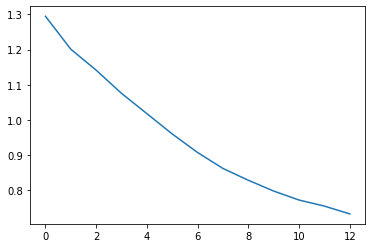

In [583]:
draw_graph(loss_total)


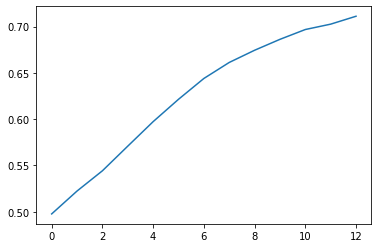

In [584]:
draw_graph(acc_total)


In [0]:
predict=test(model,x_test,batch_size,device)
save_submission(predict)